In [50]:
from netCDF4 import Dataset
import numpy as np
import datetime
import pandas as pd
from ll_xy import lonlat_to_xy

# Make table of floe coordinates and save to csv

### Code in cell below generates floe_coords.csv, and requires access to raw kuka data

### You don't need to run this, since floe_coords.csv should already be available.

In [52]:


# def get_kuka_time(n_secs):
    
#     dt0 = datetime.datetime(1970,1,1)
    
#     dt1 = dt0 + datetime.timedelta(seconds=int(n_secs))
    
#     return dt1

# kuka_dir = '/home/robbie/Dropbox/PS129/data/kuka/PS129_kuka'

# kuka_files = [
#             'kuka_stare_decon_Ka-Scat20220411-100806.nc', #D1
#             'kuka_stare_decon_Ka-Scat20220416-160103.nc', #D2
#             'kuka_stare_decon_Ku-Scat20220417-132510.nc', #D3
#             'kuka_stare_decon_Ka-Scat20220419-140451.nc', #D4
#             'kuka_stare_decon_Ku-Scat20220422-152023.nc', #D5
#         ]

# list_of_dicts = []

# for kuka_f in kuka_files:
    
#     kuka_d = Dataset(f'{kuka_dir}/{kuka_f}')
    
#     lon = ( float(kuka_d['lon'][0] ))
#     lat = ( float(kuka_d['lat'][0] ))
    
#     dt = get_kuka_time(kuka_d['start_time'][0])
    

#     list_of_dicts.append({'lon':lon,'lat':lat,'dt':dt})
    
# df = pd.DataFrame(list_of_dicts)

# df['x'], df['y'] = lonlat_to_xy(np.array(df['lon']),np.array(df['lat']),hemisphere='s')

# df.to_csv('../data/floe_coords.csv')

In [54]:
df = pd.read_csv('../data/floe_coords.csv',parse_dates=['dt'])
df

,Unnamed: 0,lon,lat,dt,x,y
0,0,-31.943802,-68.989711,2022-04-11 10:08:06,-1.229204e+06,1.971437e+06
1,1,-41.399840,-66.443841,2022-04-16 16:01:03,-1.720073e+06,1.951051e+06
2,2,-44.787591,-65.773791,2022-04-17 13:25:10,-1.883714e+06,1.897733e+06
3,3,-47.369977,-64.303512,2022-04-19 14:04:51,-2.084751e+06,1.919044e+06
4,4,-51.386509,-63.530966,2022-04-22 15:20:23,-2.279442e+06,1.820533e+06


In [58]:
df['x'].iloc[-1]

-2279441.772620012

In [63]:
transect_length = np.sqrt(np.square(df['x'].iloc[0] - df['x'].iloc[-1]) + np.square(df['y'].iloc[0] - df['y'].iloc[-1]))
transect_length/1000

1061.0241493344977

In [6]:
pmw_files = [
    'ice_conc_sh_polstere-100_multi_202204111200.nc',
    'ice_conc_sh_polstere-100_multi_202204161200.nc',
    'ice_conc_sh_polstere-100_multi_202204171200.nc',
    'ice_conc_sh_polstere-100_multi_202204191200.nc',
    'ice_conc_sh_polstere-100_multi_202204221200.nc',
            ]

pmw = []

for pmw_f in pmw_files:
    
    pmw_d = Dataset(f'../data/OSISAF_pmw/{pmw_f}')
    
    pmw.append(np.array(pmw_d['ice_conc'][0]))
    
    pmw_lon = np.array(pmw_d['lon'])
    pmw_lat = np.array(pmw_d['lat'])

In [ ]:
plt.hist()

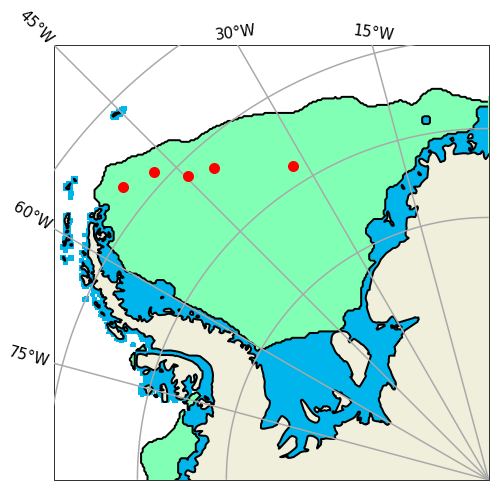

In [49]:
import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mticker
from netCDF4 import Dataset
import numpy as np
import cartopy.crs as ccrs
import cartopy
import numpy.ma as ma
import matplotlib.pyplot as plt
import pandas as pd


pmw_data = pmw[-1].copy()
pmw_data[pmw_data>0.5] = 2
pmw_data[pmw_data<0] = 1
pmw_data[pmw_data<0.5] = np.nan


# Make plot

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.SouthPolarStereo())

ax.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=9,linewidth=2)

ax.set_extent([-80, -10, -90, -65], ccrs.PlateCarree())

scat = ax.scatter(df['lon'],
                  df['lat'],
                  transform=ccrs.PlateCarree(),
                  marker='o',
                  color='r',
                  s=100,
                  zorder=15,)


###################################

lon2d_greater = ma.masked_greater(np.array(pmw_lon), -0.01)
lon2d_lesser = ma.masked_less(np.array(pmw_lon), 0)

lat2d_greater = ma.MaskedArray(np.array(pmw_lat), mask=lon2d_greater.mask)
lat2d_lesser = ma.MaskedArray(np.array(pmw_lat), mask=lon2d_lesser.mask)

for i in pmw[-1:]:

    ice_type_lesser = ma.MaskedArray(i, mask=lon2d_lesser.mask)
    ice_type_greater = ma.MaskedArray(i, mask=lon2d_greater.mask)


    cont_Great = ax.contour(lon2d_greater,
                      lat2d_greater,
                      ice_type_greater,
                      levels=[0],
                      transform=ccrs.PlateCarree(),
                      zorder=6,
                            linewidths=[2],
                      colors=['k'])


##################################


mesh = ax.pcolormesh(pmw_lon,pmw_lat,
                     pmw_data,
                         cmap='rainbow',
                     transform=ccrs.PlateCarree(),
                    vmin=0,vmax=4,zorder=5)

gl = ax.gridlines(zorder=10,color='darkgrey',linewidth=1.5)
gl.xlabel_style = {'size': 15, 'color': 'k'}

gl.ylocator = mticker.FixedLocator(np.arange(-60,-80,-5))
gl.xlocator = mticker.FixedLocator(np.arange(0,-91,-15))

gl.ylabels_left = True
gl.xlabels_top = True

plt.savefig('../figures/floes_map.jpg',dpi=400,bbox_inches='tight')

plt.show()

